Baseline Evaluation for Weather Data

- Done via an ARIMA model with HPO CV

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import ARIMA
from pmdarima.model_selection import SlidingWindowForecastCV
import optuna

/storage/.dsw_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read in & Preprocess data

In [3]:
# Read in data
years = ["2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("./data/2023_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"./data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()


all_data["ISO Time"] = pd.to_datetime(all_data["ISO Time"])
all_data.set_index("ISO Time", inplace=True)
hourly_avg = all_data.resample("H").mean()

Data Collected


Plot Data

<Figure size 1400x500 with 0 Axes>

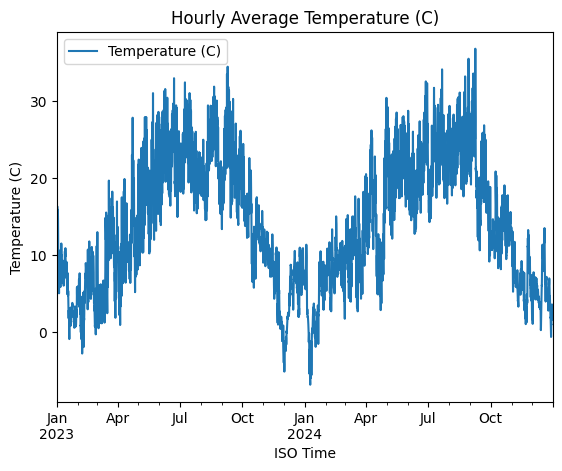

<Figure size 1400x500 with 0 Axes>

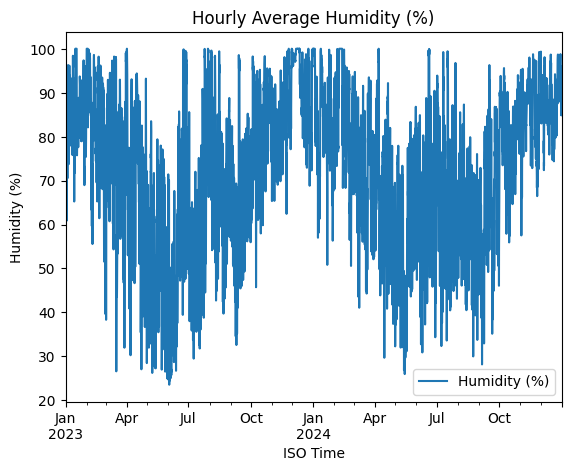

<Figure size 1400x500 with 0 Axes>

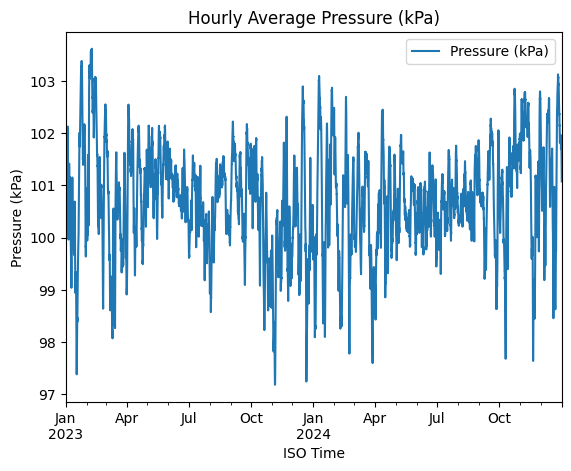

<Figure size 1400x500 with 0 Axes>

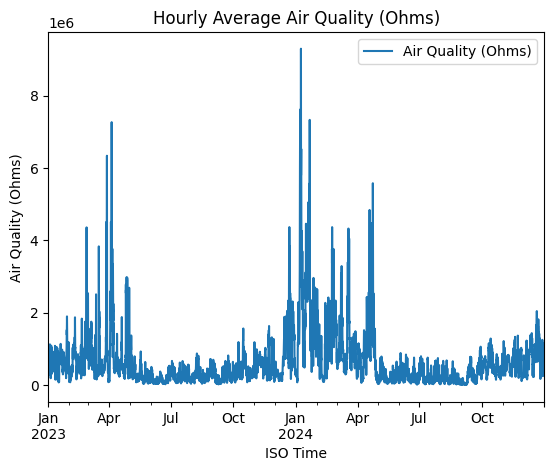

In [4]:
var_names = columns[1:]

for variable in var_names:
    plt.figure(figsize=(14, 5))
    hourly_avg.plot(y=variable)
    plt.title(f"Hourly Average {variable}")
    plt.ylabel(variable)
    plt.show()

In [5]:
data = hourly_avg["Temperature (C)"].dropna()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()

look_back = 168  # 7 days
horizon = 24     # 1 day
test_size = int(len(data_scaled) * 0.1)
train_data = data_scaled[:-test_size]
test_data = data_scaled[-test_size-look_back:]  # Include lookback for testing

CV HPO

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

def objective(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)

    try:
        model = ARIMA(order=(p, d, q), suppress_warnings=True)
        cv = SlidingWindowForecastCV(window_size=look_back, step=24, h=horizon, initial=train_data.shape[0] - 7*horizon)
        scores = []
        for y_train_cv, y_test_cv in cv.split(train_data):
            model.fit(y_train_cv)
            y_pred_cv = model.predict(n_periods=len(y_test_cv))
            score = mean_absolute_percentage_error(y_test_cv, y_pred_cv)
            scores.append(score)
        return np.mean(scores)
    except Exception as e:
        return float('inf')  # If model fails, return high loss

In [7]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, timeout=600)

print("Best ARIMA params:", study.best_params)

[I 2025-06-13 08:32:03,306] A new study created in memory with name: no-name-66d36de7-4a34-45eb-a6df-00aa3c868692
[I 2025-06-13 08:32:03,308] Trial 0 finished with value: inf and parameters: {'p': 1, 'd': 2, 'q': 3}. Best is trial 0 with value: inf.
[I 2025-06-13 08:32:03,310] Trial 1 finished with value: inf and parameters: {'p': 1, 'd': 2, 'q': 4}. Best is trial 0 with value: inf.
[I 2025-06-13 08:32:03,311] Trial 2 finished with value: inf and parameters: {'p': 0, 'd': 0, 'q': 0}. Best is trial 0 with value: inf.
[I 2025-06-13 08:32:03,312] Trial 3 finished with value: inf and parameters: {'p': 0, 'd': 0, 'q': 0}. Best is trial 0 with value: inf.
[I 2025-06-13 08:32:03,313] Trial 4 finished with value: inf and parameters: {'p': 2, 'd': 2, 'q': 1}. Best is trial 0 with value: inf.
[I 2025-06-13 08:32:03,314] Trial 5 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 1}. Best is trial 0 with value: inf.
[I 2025-06-13 08:32:03,315] Trial 6 finished with value: inf and param

Best ARIMA params: {'p': 1, 'd': 2, 'q': 3}


Best Model

In [8]:
# Retrain best ARIMA on full train set
best_order = (study.best_params["p"], study.best_params["d"], study.best_params["q"])
model = ARIMA(order=best_order, suppress_warnings=True)
model.fit(train_data)

# Forecast next 24 hours using last 168-hour context in test set
forecast = model.predict(n_periods=24)

# Inverse transform to original scale
forecast_inv = scaler.inverse_transform(forecast.reshape(-1, 1)).flatten()
y_true_inv = scaler.inverse_transform(test_data[look_back:look_back+horizon].reshape(-1, 1)).flatten()

/storage/.dsw_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/.dsw_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluate and Plot Forecasts

In [9]:
rmse = np.sqrt(mean_squared_error(y_true_inv, forecast_inv))
mae = mean_absolute_error(y_true_inv, forecast_inv)
mape = mean_absolute_percentage_error(y_true_inv, forecast_inv)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 1.3784
MAE: 1.1253
MAPE: 7.08%


/storage/.dsw_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/.dsw_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/.dsw_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/.dsw_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/.dsw_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

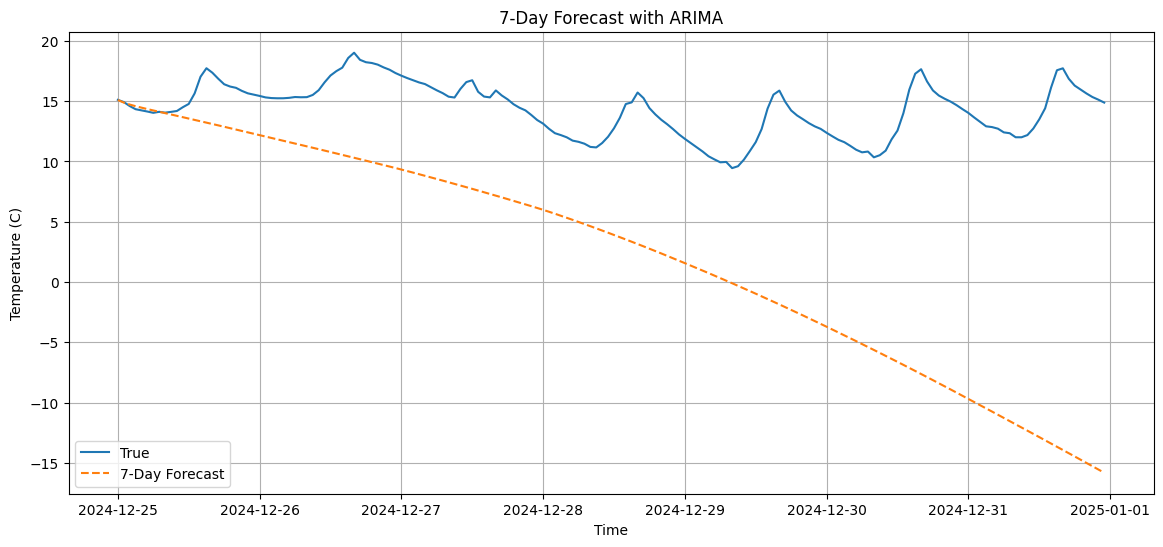

In [10]:
multi_forecast = []
context = test_data[:look_back]

for _ in range(7):
    model = ARIMA(order=best_order, suppress_warnings=True)
    model.fit(context)
    pred = model.predict(n_periods=24)
    multi_forecast.extend(pred)
    context = np.append(context[24:], pred)

multi_forecast_inv = scaler.inverse_transform(np.array(multi_forecast).reshape(-1, 1)).flatten()
true_7day = scaler.inverse_transform(test_data[look_back:look_back+7*24].reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(data.index[-7*24:], true_7day, label="True")
plt.plot(data.index[-7*24:], multi_forecast_inv, label="7-Day Forecast", linestyle="--")
plt.title("7-Day Forecast with ARIMA")
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.legend()
plt.grid()
plt.show()